## Upscaling galaxy images using Variational Autoencoders (VAEs)
*Note: This project was originally done for the class [ASTR 31200: Computational Techniques in Astrophysics](http://graduateannouncements.uchicago.edu/graduate/departmentofastronomyandastrophysics/), and has since been adapted as a standalone project.*

Due to the limits of physical telescopes, the resolution of captured images is generally bound by the size of the telescope, though methods exist to reduce error and noise. The purpose of this project is to generate "upscaled" images of galaxies using Variational Autoencoders, which can then be used to test various methods of analyzing galaxies. 

The training and test data sets for this project are extracted from the [Legacy survey](https://www.legacysurvey.org/viewer) online database, where, in some areas of the sky, there are images both obtained from the [Sloan Digital Sky Survey](https://www.sdss.org/) (SDSS) on a relatively small telescope and from the [Hyper-Supreme Camera (HSC) survey](https://hsc.mtk.nao.ac.jp/ssp/survey/) on an 8-meter telescope. So, there exist both lower and higher quality images of the same galaxy, as shown below. 

![Galaxy image from the HSC, high quality](gal_hsc_128x128/16.8302_-0.1597_hscs.jpg)

![Galaxy image from the SDSS, low quality](gal_sdss_128x128/16.8302_-0.1597_sdss.jpg)

The general concept behind a VAE is that an input (in this case an image) can be represented as a point in a latent space, typically a lower dimensional space where the dimensions describe components of the input. Points can then be sampled from this space and decoded to generate a new output that mimicks the input. As such, a VAE can be trained on a set of images as to generate better quality images based on the intrinsic components within the latent space. 

# <font color='blue'>ASTR 21100/312</font>

# <font color='blue'>"*Computational Techniques in Astrophysics*"</font>

## <font color='blue'>a final project option</font>

## <font color='blue'>Using neural networks to generate images of galaxies with properties of a survey using their images from a different suervey</font>
    
## <font color='blue'>Lead instructor(s) for this project: Zewei Wu </font>
    
### <font color='blue'>Undergraduate students: 50 points + possible extra credit points</font>
        
    
### <font color='blue'>Part I is due Fri, Feb 28 by 9pm; Part II is due Fri, Mar 7 , 9pm</font> 

### <font color='blue'>Final version is due Tue, Mar 11, 9pm</font> 



### <font color='blue'>Background</font>

Galaxies are distant stellar systems and are one of the main subjects of astronomical research. 
We are located in one of them - the Milky Way. Often methods used to analyze galaxies are tested 
on artificially produced images of these systems that are constructed from an underlying model of their
light distribution, taking into account observational effects, such as noise, background light, etc.

In the last two decades, several approaches have been developed to generate artificial images of scenes, objects, animals, or humans
either from completely random input (noise) or starting from low-quality images. Over the past decade, some of these approaches based on neural networks have produced rapid and impressive progress in the quality and realism of the images. 
You can generate examples of [images of human faces](https://this-person-does-not-exist.com/en) produced by such an algorithm (these images are artificial and do not correspond to any face of actual living people). And such algorithms can impressively enhance very dimly lit scenes (you can see examples if you scroll down to the end of [this page](https://keras.io/examples/vision/mirnet/)). Such algorithms are also used for ["style transfer"](https://towardsdatascience.com/style-transfer-with-gans-on-hd-images-88e8efcf3716) where an image (a photo) is transformed into a similar image but with some specific style, as though it was painted by a specific painter.


One of the most effective approaches for such applications is based on neural networks and is called [Generative Adversarial Networks](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/) (GANs), proposed by Ian Goodfellow and collaborators in a [2014 paper](https://arxiv.org/abs/1406.2661). Generative is because the method produces something meaningful like an image. Adversarial Networks refer to the two neural networks used in such approach: Generator network is trained to produce an image from an input image and Discriminator network evaluates how probable it is that image is from a data set similar to the training data, but is much larger. The discriminator output is sent back to the generative network. 

The training procedure for Generator network is to maximize the probability of Discriminator of making a mistake, while Discriminator is trained to maximize the probability it makes correct classification of input image. The procedure is thus adversarial: the generator algorithm learns to produce better "forgeries", while discriminator is trained to become better at recognizing what is a forgery and what is real. 

In this project you will use such approach to generate artificial images of galaxies. 

There are two options for this project: 

* In the base option you need to set up and train adversarial neural networks to generate random artificial images of galaxies from random input. Examples of similar networks that will be provided to you. 


* In the second option you will train convolutional autoenconder neural networks to generate enhanced images of galaxies from lower-quality images of the same galaxies. 


Description below is for the section option of the project. 

The training and test data sets for this project are extracted from the [Legacy survey](https://www.legacysurvey.org/viewer) online database, where in some areas of the sky images obtained with the [Sloan Digital Sky Survey](https://www.sdss.org/) (SDSS) on a relatively small telescope and images from the [Hyper-Supreme Camera (HSC) survey](https://hsc.mtk.nao.ac.jp/ssp/survey/) obtained on an 8-meter telescope exist. So one can get lower and higher quality images of the same galaxy, as shown in a few examples below. 

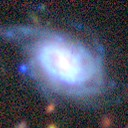


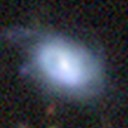

We begin by reading in the data and organizing it into training and testing data.

In [3]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf

In [12]:
# Load in data
hr_path = "gal_hsc_128x128"
hr = keras.utils.image_dataset_from_directory(hr_path, shuffle=False, labels=None,
                                                   image_size=(64, 64),
                                                   batch_size=1,
                                                   pad_to_aspect_ratio=True)

lr_path = "gal_sdss_128x128"
lr = keras.utils.image_dataset_from_directory(lr_path, shuffle=False, labels=None,
                                                   image_size=(64, 64),
                                                   batch_size=1,
                                                   pad_to_aspect_ratio=True)

full_data = tf.data.Dataset.zip((lr, hr))
full_data = full_data.map(lambda x, y: tf.stack([x[0], y[0]], axis=0))
print(next(iter(full_data)).shape)

Found 6557 files.
Found 6557 files.
(2, 64, 64, 3)


In [ ]:
# Display images to confirm that one set has higher quality images
def display_imgs(ds, n_imgs = 10):
    """Given a combined dataset of size (n, 2, ...), show a given number of corresponding images."""

    # Randomize order and create iterator
    rand_ds = ds.shuffle(len(ds))
    ds_iter = rand_ds.as_numpy_iterator()

    # Set up subplots
    fig, axes = plt.subplots(2, n_imgs)
    fig.set_size_inches(2*n_imgs, 4)

    for i in range(n_imgs):
        # Get each image
        images = next(ds_iter)
        image1 = images[0].astype("int32")
        image2 = images[1].astype("int32")

        # Plot images
        ax = axes[0, i]
        ax.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = axes[1, i]
        ax.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

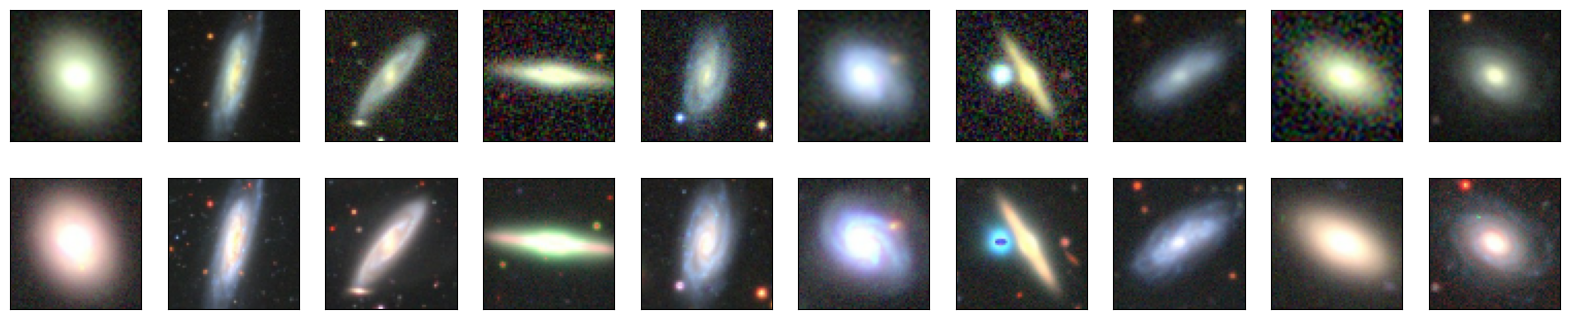

In [22]:
display_imgs(full_data, 10)

In [ ]:
# Train-test split function
def train_test_split(ds, p_train: 0.8):
    """Split a dataset into training and testing datasets, with ``p_train`` being the proportion of training data."""

    rand_ds = ds.shuffle(len(ds))


